<h1> Imports

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFdr
from scipy.signal import butter, lfilter, filtfilt, freqz
from scipy import signal

<h1> Fitlering Functions

In [212]:
def pca_and_inverse(df):
    pca = PCA(0.80).fit(df)
    components = pca.transform(df)
    return pca.inverse_transform(components)

In [213]:
record_export_folder = 'recordings'
# keep_cols = ['EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8'] # ['Timestamp', 'EEG.Counter', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8']
keep_cols = ["O1/theta","O1/alpha","O1/betaL","O1/betaH","O1/gamma",
             "O2/theta","O2/alpha","O2/betaL","O2/betaH","O2/gamma"]

def load_df(file_name):
    file_path = os.path.join(record_export_folder, file_name)
    return pd.read_csv(file_path, skiprows=0, header=0)

def trim_cols(df):
    return df[keep_cols]

<h1> Data from 4 Sensors

In [214]:
df = trim_cols(load_df('psychopy_sultan_recording_{}.csv'.format(0)))

In [215]:
df.values[2]

array([0.809, 1.082, 1.081, 0.868, 0.529, 0.494, 0.476, 0.122, 0.219,
       0.47 ])

In [216]:
pca_df = pca_and_inverse(df)

In [217]:
pca_df.shape

(600, 10)

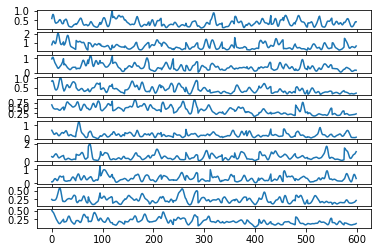

In [218]:
subplot = 0
fig, axs = plt.subplots(10)
for col in df.columns:
    axs[subplot].plot(df[col].values)
    subplot += 1

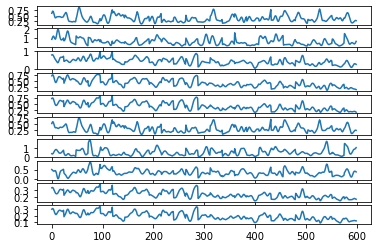

In [222]:
subplot = 0
fig, axs = plt.subplots(10)
for col in range(pca_df.shape[1]):
    axs[subplot].plot(pca_df[:,col])
    subplot += 1

<h1> Training Data

In [5]:
from sklearn.preprocessing import minmax_scale

In [35]:
seconds_to_check = 3
total_data_points = 600
interval_range = int(8 * seconds_to_check)
data_points = int(total_data_points / interval_range)

def split_to_training_data(df):
    total_data = []
    for interval_start in range(0, interval_range * data_points, interval_range):
        temp_data = []
        for col in range(0, df.shape[1]):
            temp_data.append(df[interval_start:interval_start + interval_range, col])
        
        total_data.append(temp_data)
        
    return np.asarray(total_data)

def create_target_data(data, target):
    return np.asarray([target] * data.shape[0])

def scale_and_normalize(data):
    print(data.shape)
    for sample in range(data.shape[0]):
        for col in range(data.shape[1]):
            data[sample,col,:] = minmax_scale(data[sample,col,:])
#         for feature in range(data.shape[1]):
#             data[sample,feature,:] = minmax_scale(data[sample,feature,:])
#             data[:,col] = minmax_scale(data[:,col])
    return data
#     return minmax_scale(data)

In [225]:
targets = range(0, 4)
total_train_x = []
total_train_y = []
for target in targets:
    df = trim_cols(load_df('psychopy_sultan_recording_{}.csv'.format(target)))
    total_data = np.asarray(df.values)
    pca_df = pca_and_inverse(df)
    train_x = split_to_training_data(pca_df)
#     train_x = scale_and_normalize(train_x)
    train_y = create_target_data(train_x, target)
    if target == targets[0]:
        total_train_x = train_x
        total_train_y = train_y
    else:
        total_train_x = np.concatenate((total_train_x, train_x))
        total_train_y = np.concatenate((total_train_y, train_y))

In [226]:
total_train_x.shape

(100, 10, 24)

In [227]:
train_x, validation_x, train_y, validation_y = train_test_split(total_train_x, total_train_y, test_size = 0.2)

In [228]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam, Adamax, RMSprop, Adagrad
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU, BatchNormalization, LayerNormalization, ActivityRegularization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

In [229]:
def create_model():
    model = Sequential()
    model.add(LSTM(100, input_shape=(train_x.shape[1:]), return_sequences=True))
#     model.add(Dropout(0.2))
    model.add(ActivityRegularization(l2=0.001))
#     model.add(BatchNormalization())

#     model.add(LSTM(8, input_shape=(train_x.shape[1:]), return_sequences=True))
#     model.add(Dropout(0.3))
#     model.add(ActivityRegularization(l2=0.001))
#     model.add(BatchNormalization())

    model.add(LSTM(20, input_shape=(train_x.shape[1:]), return_sequences=False))
#     model.add(Dropout(0.5))
#     model.add(ActivityRegularization(l2=0.001))
#     model.add(BatchNormalization())

#     model.add(Dense(16))

    model.add(Dense(4, activation="softmax"))
    
    return model

In [230]:
EPOCHS = 200
BATCH_SIZE = 8
NAME= "models\BEST"

In [231]:
model = create_model()
    
opt = tf.keras.optimizers.Adam(0.1)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt, metrics=['acc'])

callbacks = [
#     TensorBoard(f"logs\LSTM-{int(time.time())}"),
    ReduceLROnPlateau(patience=15, factor=0.9),
    EarlyStopping(patience=40),
    ModelCheckpoint(filepath=f"models\Best", monitor='val_loss', verbose=2, save_weights_only=True, save_best_only=True, mode='min')
]
    
history = model.fit(train_x,
                    train_y,
                    batch_size= BATCH_SIZE,
                    epochs = EPOCHS,
                    validation_data=(validation_x, validation_y), 
                    callbacks=callbacks)

Epoch 1/200
 1/10 [==>...........................] - ETA: 0s - loss: 1.3410 - acc: 0.6250
Epoch 00001: val_loss improved from inf to 1.47252, saving model to models\Best
10/10 [==============================] - 2s 176ms/step - loss: 2.1543 - acc: 0.2750 - val_loss: 1.4725 - val_acc: 0.1500
Epoch 2/200
 1/10 [==>...........................] - ETA: 0s - loss: 1.5006 - acc: 0.2500
Epoch 00002: val_loss did not improve from 1.47252
10/10 [==============================] - 0s 6ms/step - loss: 1.4531 - acc: 0.2750 - val_loss: 1.4903 - val_acc: 0.1500
Epoch 3/200
 1/10 [==>...........................] - ETA: 0s - loss: 1.4155 - acc: 0.3750
Epoch 00003: val_loss improved from 1.47252 to 1.39878, saving model to models\Best
10/10 [==============================] - 0s 9ms/step - loss: 1.4288 - acc: 0.2125 - val_loss: 1.3988 - val_acc: 0.1500
Epoch 4/200
 1/10 [==>...........................] - ETA: 0s - loss: 1.3347 - acc: 0.3750
Epoch 00004: val_loss did not improve from 1.39878
10/10 [========

 1/10 [==>...........................] - ETA: 0s - loss: 0.9498 - acc: 0.6250
Epoch 00032: val_loss improved from 1.35800 to 1.23991, saving model to models\Best
10/10 [==============================] - 0s 9ms/step - loss: 1.2488 - acc: 0.5000 - val_loss: 1.2399 - val_acc: 0.3000
Epoch 33/200
 1/10 [==>...........................] - ETA: 0s - loss: 1.1064 - acc: 0.6250
Epoch 00033: val_loss did not improve from 1.23991
10/10 [==============================] - 0s 6ms/step - loss: 1.3980 - acc: 0.3750 - val_loss: 1.5728 - val_acc: 0.2000
Epoch 34/200
 1/10 [==>...........................] - ETA: 0s - loss: 1.4186 - acc: 0.2500
Epoch 00034: val_loss did not improve from 1.23991
10/10 [==============================] - 0s 6ms/step - loss: 1.2956 - acc: 0.3875 - val_loss: 1.5787 - val_acc: 0.3000
Epoch 35/200
 1/10 [==>...........................] - ETA: 0s - loss: 0.8000 - acc: 0.5000
Epoch 00035: val_loss did not improve from 1.23991
10/10 [==============================] - 0s 6ms/step - 

 1/10 [==>...........................] - ETA: 0s - loss: 1.1758 - acc: 0.3750
Epoch 00063: val_loss did not improve from 1.23991
10/10 [==============================] - 0s 6ms/step - loss: 1.0426 - acc: 0.5000 - val_loss: 1.4204 - val_acc: 0.3000
Epoch 64/200
 1/10 [==>...........................] - ETA: 0s - loss: 1.0904 - acc: 0.5000
Epoch 00064: val_loss did not improve from 1.23991
10/10 [==============================] - 0s 6ms/step - loss: 0.9678 - acc: 0.6250 - val_loss: 1.3540 - val_acc: 0.5500
Epoch 65/200
 1/10 [==>...........................] - ETA: 0s - loss: 0.9099 - acc: 0.5000
Epoch 00065: val_loss did not improve from 1.23991
10/10 [==============================] - 0s 6ms/step - loss: 1.1218 - acc: 0.5000 - val_loss: 1.3695 - val_acc: 0.4000
Epoch 66/200
 1/10 [==>...........................] - ETA: 0s - loss: 0.7836 - acc: 0.8750
Epoch 00066: val_loss did not improve from 1.23991
10/10 [==============================] - 0s 6ms/step - loss: 0.9922 - acc: 0.5875 - val_

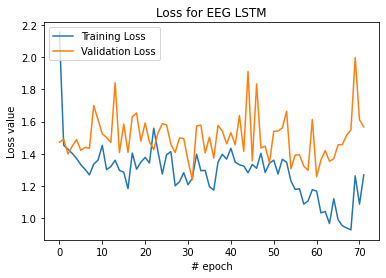

In [232]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss for EEG LSTM')
plt.ylabel('Loss value')
plt.xlabel('# epoch')
plt.legend(loc="upper left")
plt.show()

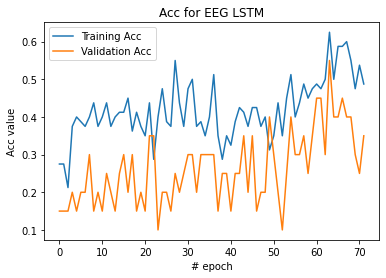

In [233]:
plt.plot(history.history['acc'], label='Training Acc')
plt.plot(history.history['val_acc'], label='Validation Acc')
plt.title('Acc for EEG LSTM')
plt.ylabel('Acc value')
plt.xlabel('# epoch')
plt.legend(loc="upper left")
plt.show()

In [105]:
model.load_weights(f"models\Best")

In [24]:
train_x.shape

(337, 12, 128)

In [34]:
pred = model.predict(train_x[0].reshape(-1, train_x.shape[1], train_x.shape[2]))

In [35]:
pred

array([[3.3189676e-04, 4.2085871e-03, 6.9821896e-03, 2.4181621e-03,
        2.3798265e-04, 2.1329962e-03, 5.0884534e-02, 6.4253420e-02,
        8.6855030e-01]], dtype=float32)

In [36]:
np.argmax(pred)

8

In [37]:
train_y[:10]

array([8, 7, 1, 2, 1, 1, 6, 1, 3, 7])

In [185]:
model.save_weights('models\model.h5')
model_json = model.to_json()
with open('models\model.json', "w") as json_file:
    json_file.write(model_json)